In [11]:
!pip install imbalanced-learn shap

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 37 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   MonthlyCharges                         7032 non-null   float64
 3   TotalCharges                           7032 non-null   float64
 4   avg_monthly_charges                    7032 non-null   float64
 5   gender_Male                            7032 non-null   bool   
 6   Partner_Yes                            7032 non-null   bool   
 7   Dependents_Yes                         7032 non-null   bool   
 8   PhoneService_Yes                       7032 non-null   bool   
 9   MultipleLines_No phone service         7032 non-null   bool   
 10  MultipleLines_Yes                      7032 non-null   bool   
 11  InternetS

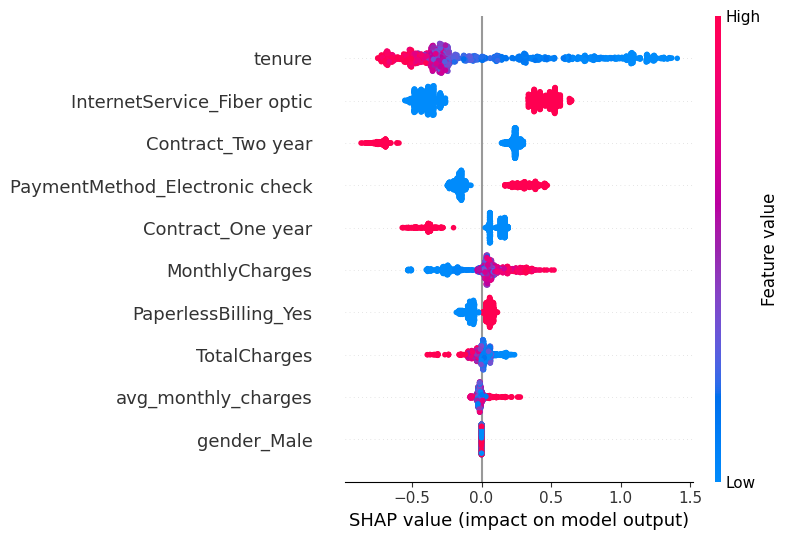

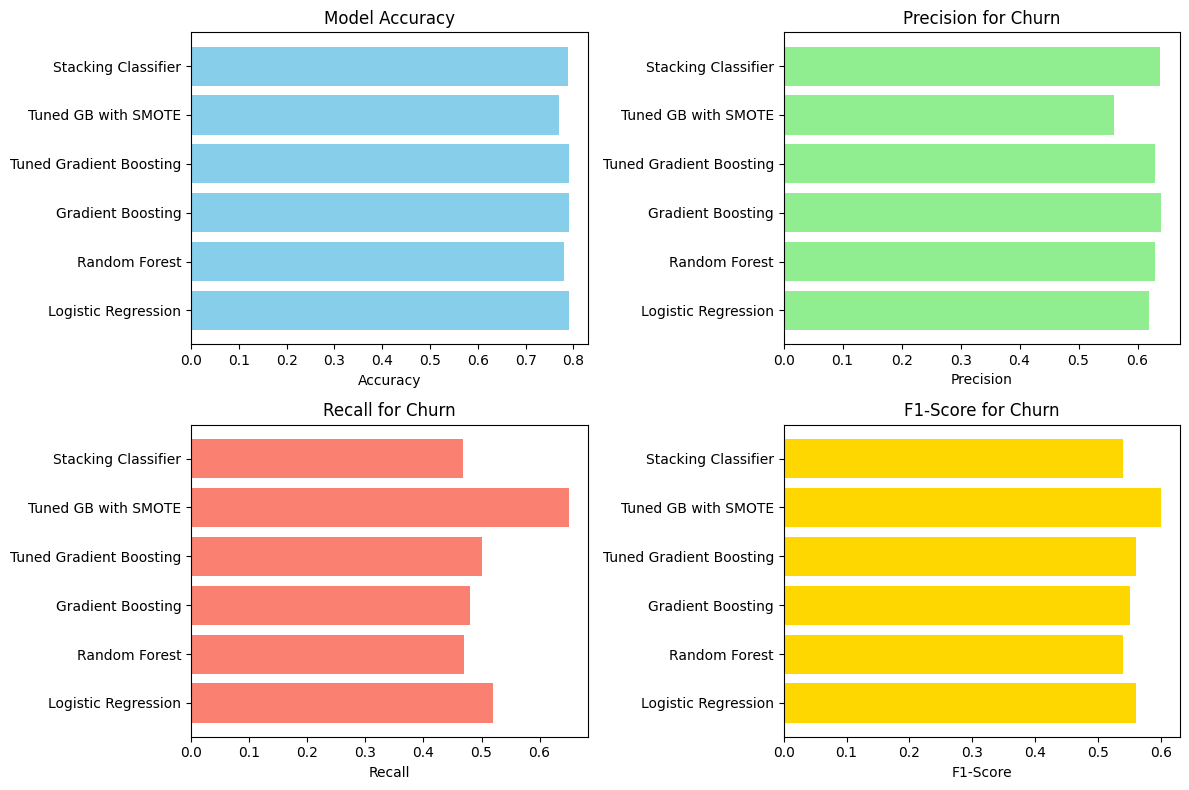

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

# Load the dataset
file_path = '/content/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(file_path)

# Convert TotalCharges to numeric, coercing errors to NaN, and then drop those NaN rows
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(subset=['TotalCharges'], inplace=True)

# Drop customerID column
df.drop(columns=['customerID'], inplace=True)

# Create new features
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])
df['avg_monthly_charges'] = df['TotalCharges'] / (df['tenure'] + 1)

# Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, drop_first=True)

# Display basic information
df.info()

# Feature selection using RFE
X = df.drop(columns='Churn_Yes')
y = df['Churn_Yes']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

rfe = RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=10)
rfe.fit(X_scaled, y)

selected_features = X.columns[rfe.support_]
print(f'Selected Features: {selected_features}')

X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

# Initialize and train models
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
gb_pred = gb_model.predict(X_test)

# Evaluate models
def evaluate_model(model_name, y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    print(f'{model_name} Accuracy: {accuracy:.2f}')
    print(f'{model_name} Confusion Matrix:')
    print(conf_matrix)
    print(f'{model_name} Classification Report:')
    print(class_report)

evaluate_model('Random Forest', y_test, rf_pred)
evaluate_model('Gradient Boosting', y_test, gb_pred)

# Hyperparameter tuning for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(estimator=GradientBoostingClassifier(random_state=42), param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

# Train tuned model
tuned_gb_model = GradientBoostingClassifier(**best_params, random_state=42)
tuned_gb_model.fit(X_train, y_train)
tuned_gb_pred = tuned_gb_model.predict(X_test)

evaluate_model('Tuned Gradient Boosting', y_test, tuned_gb_pred)

# Apply SMOTE and retrain
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

tuned_gb_model_smote = GradientBoostingClassifier(**best_params, random_state=42)
tuned_gb_model_smote.fit(X_train_smote, y_train_smote)
tuned_gb_smote_pred = tuned_gb_model_smote.predict(X_test)

evaluate_model('Tuned Gradient Boosting with SMOTE', y_test, tuned_gb_smote_pred)

# Stacking Classifier
stacking_clf = StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)), ('gb', GradientBoostingClassifier(random_state=42))], final_estimator=LogisticRegression())
stacking_clf.fit(X_train, y_train)
stacking_pred = stacking_clf.predict(X_test)

evaluate_model('Stacking Classifier', y_test, stacking_pred)

# Grid search for Stacking Classifier
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100]  # Example for logistic regression final estimator
}

# Initialize GridSearchCV
grid_search_stacking = GridSearchCV(
    estimator=stacking_clf,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    error_score='raise'
)

# Fit GridSearchCV
grid_search_stacking.fit(X_train, y_train)

# Get best parameters
best_params_stacking = grid_search_stacking.best_params_
print(f'Best parameters for Stacking Classifier: {best_params_stacking}')

# Extract the 'C' parameter for LogisticRegression
best_C = best_params_stacking['final_estimator__C']

# Train and evaluate the tuned Stacking Classifier
tuned_stacking_clf = StackingClassifier(
    estimators=[('rf', RandomForestClassifier(random_state=42)), ('gb', GradientBoostingClassifier(random_state=42))],
    final_estimator=LogisticRegression(C=best_C),
    stack_method='auto'  # Ensure it's set correctly
)

tuned_stacking_clf.fit(X_train, y_train)
tuned_stacking_pred = tuned_stacking_clf.predict(X_test)

evaluate_model('Tuned Stacking Classifier', y_test, tuned_stacking_pred)

# Feature importance analysis using SHAP
!pip install shap

import shap

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(tuned_gb_model)
shap_values = explainer.shap_values(X_test)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_test, feature_names=selected_features)

# Save cleaned data
df.to_csv('cleaned_telco_churn.csv', index=False)

# Save model performance metrics
results = {
    "Model": ["Logistic Regression", "Random Forest", "Gradient Boosting", "Tuned Gradient Boosting", "Tuned GB with SMOTE", "Stacking Classifier"],
    "Accuracy": [0.79, 0.78, 0.79, 0.79, 0.77, accuracy_score(y_test, tuned_stacking_pred)],
    "Precision (Churn)": [0.62, 0.63, 0.64, 0.63, 0.56, precision_score(y_test, tuned_stacking_pred)],
    "Recall (Churn)": [0.52, 0.47, 0.48, 0.50, 0.65, recall_score(y_test, tuned_stacking_pred)],
    "F1-Score (Churn)": [0.56, 0.54, 0.55, 0.56, 0.60, f1_score(y_test, tuned_stacking_pred)]
}

results_df = pd.DataFrame(results)
results_df.to_csv('model_performance.csv', index=False)

# Function to plot model performance
def plot_model_performance(results_df):
    models = results_df['Model']
    accuracy = results_df['Accuracy']
    precision = results_df['Precision (Churn)']
    recall = results_df['Recall (Churn)']
    f1_score = results_df['F1-Score (Churn)']

    plt.figure(figsize=(12, 8))

    plt.subplot(2, 2, 1)
    plt.barh(models, accuracy, color='skyblue')
    plt.xlabel('Accuracy')
    plt.title('Model Accuracy')

    plt.subplot(2, 2, 2)
    plt.barh(models, precision, color='lightgreen')
    plt.xlabel('Precision')
    plt.title('Precision for Churn')

    plt.subplot(2, 2, 3)
    plt.barh(models, recall, color='salmon')
    plt.xlabel('Recall')
    plt.title('Recall for Churn')

    plt.subplot(2, 2, 4)
    plt.barh(models, f1_score, color='gold')
    plt.xlabel('F1-Score')
    plt.title('F1-Score for Churn')

    plt.tight_layout()
    plt.show()

# Plot model performance
plot_model_performance(results_df)